In [1]:
!pip install -q efficientnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np 
import pandas as pd 
import os
import re
import seaborn as sns
import math
import random

from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow as tf, re, math
import tensorflow.keras.backend as K

import efficientnet.tfkeras as efn

from kaggle_datasets import KaggleDatasets

In [3]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [4]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_PATH = KaggleDatasets().get_gcs_path('melanoma-512x512')

# Configuration
EPOCHS = 14
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [512, 512]
print(BATCH_SIZE)
print(AUTO)

128
-1


In [5]:
def append_path(pre):
    return np.vectorize(lambda file: os.path.join(GCS_DS_PATH, pre, file))

In [6]:
sub = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')

In [7]:
train = pd.read_csv("../input/siim-isic-melanoma-classification/train.csv")
test = pd.read_csv("../input/siim-isic-melanoma-classification/test.csv")

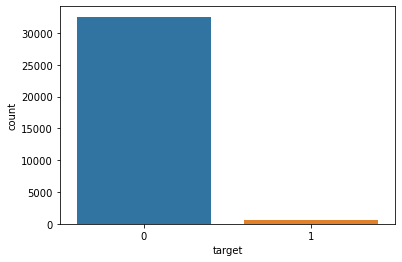

In [8]:
sns.countplot(train['target'])

In [9]:
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

CLASSES = [0,1] 

print(TRAINING_FILENAMES)

['gs://kds-df537acf009e02b1d4427274d18970a1b0101b1ca26824bae39b5b4b/train00-2182.tfrec', 'gs://kds-df537acf009e02b1d4427274d18970a1b0101b1ca26824bae39b5b4b/train01-2185.tfrec', 'gs://kds-df537acf009e02b1d4427274d18970a1b0101b1ca26824bae39b5b4b/train02-2193.tfrec', 'gs://kds-df537acf009e02b1d4427274d18970a1b0101b1ca26824bae39b5b4b/train03-2182.tfrec', 'gs://kds-df537acf009e02b1d4427274d18970a1b0101b1ca26824bae39b5b4b/train04-2167.tfrec', 'gs://kds-df537acf009e02b1d4427274d18970a1b0101b1ca26824bae39b5b4b/train05-2171.tfrec', 'gs://kds-df537acf009e02b1d4427274d18970a1b0101b1ca26824bae39b5b4b/train06-2175.tfrec', 'gs://kds-df537acf009e02b1d4427274d18970a1b0101b1ca26824bae39b5b4b/train07-2174.tfrec', 'gs://kds-df537acf009e02b1d4427274d18970a1b0101b1ca26824bae39b5b4b/train08-2177.tfrec', 'gs://kds-df537acf009e02b1d4427274d18970a1b0101b1ca26824bae39b5b4b/train09-2178.tfrec', 'gs://kds-df537acf009e02b1d4427274d18970a1b0101b1ca26824bae39b5b4b/train10-2174.tfrec', 'gs://kds-df537acf009e02b1d4427

In [10]:
# TRAINING_FILENAMES, VALIDATION_FILENAMES = train_test_split(TRAINING_FILENAMES, test_size=0.15, random_state=907)

# print(TRAINING_FILENAMES)
# print(VALIDATION_FILENAMES)

In [11]:
ROT_ = 180.0
SHR_ = 2.0
HZOOM_ = 8.0
WZOOM_ = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0

dim = 512

In [12]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, DIM=512):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 #fix for size 331
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

In [13]:
def random_rotate(x: tf.Tensor) -> tf.Tensor:
    """Rotation augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """

    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(x, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

In [14]:
def random_central_crop(x: tf.Tensor) -> tf.Tensor:
    x = tf.image.central_crop(x, random.uniform(0.9,1.0))
    x = tf.image.resize(x, IMAGE_SIZE)
    return x
    

In [15]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        #"class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
        "target": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    #label = tf.cast(example['class'], tf.int32)
    label = tf.cast(example['target'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_name": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['image_name']
    return image, idnum # returns a dataset of image(s)

def aug_image(image, aug):
    if '0' in aug:
        image = image
    if '1' in aug:
        image = tf.image.flip_left_right(image)
    if '2' in aug:
        image = tf.image.flip_up_down(image)
    if '3' in aug:
        image = tf.image.rot90(image, 1)
    if '4' in aug:
        image = tf.image.rot90(image, 2)
    if '5' in aug:
        image = tf.image.rot90(image, 3) 
    return image
    
    
def read_unlabeled_test_tfrecord(example, aug):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_name": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    image = aug_image(image, aug)
    idnum = example['image_name']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def load_test_dataset(aug, filenames, labeled=False, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(lambda x: read_unlabeled_test_tfrecord(x, aug), num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = transform(image,DIM=dim)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    #image = random_rotate(image)
    #image = random_central_crop(image)
    #image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.7, 1.25)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(aug, ordered=False):
    dataset = load_test_dataset(aug, TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
# NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_TEST_IMAGES))

Dataset: 32692 training images, 10982 unlabeled test images


In [16]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0002)

In [17]:
def scheduler(epoch):
        return 2e-4 * 0.5**epoch

In [18]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_auc', factor=0.4, patience=1, verbose=1, mode='max'
            )

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_auc', mode = 'max', patience = 4, 
                                                      verbose = 1, min_delta = 0.0001, restore_best_weights = True)

In [20]:
with strategy.scope():
    base_model = efn.EfficientNetB4(
            input_shape=(*IMAGE_SIZE, 3),
            weights='noisy-student',
            include_top=False
        )
    auc = tf.keras.metrics.AUC()

71680000/71678424 [==============================] - 1s 0us/step


In [21]:
with strategy.scope():
    model = tf.keras.Sequential([
        base_model,
        L.GlobalAveragePooling2D(),  
        L.Dense(1, activation='sigmoid')
    ])
    
    
model.compile(
    optimizer=adam,
    #loss = 'binary_crossentropy',
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.2),
    metrics=['binary_crossentropy', auc]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 16, 16, 1792)      17673816  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1793      
Total params: 17,675,609
Trainable params: 17,550,409
Non-trainable params: 125,200
_________________________________________________________________


In [22]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

In [23]:
sv = tf.keras.callbacks.ModelCheckpoint(
    'efficientnetb4.h5', monitor='val_auc', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch')

In [24]:
history = model.fit(
    get_training_dataset(), 
    epochs=EPOCHS, 
    callbacks=[lr_schedule],
    steps_per_epoch=STEPS_PER_EPOCH,
    #validation_data=get_validation_dataset(ordered=True)
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 1/14
255/255 [==============================] - 125s 491ms/step - binary_crossentropy: 0.1627 - auc: 0.7015 - loss: 0.3606 - lr: 2.0000e-04

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 2/14
255/255 [==============================] - 119s 466ms/step - binary_crossentropy: 0.1516 - auc: 0.8236 - loss: 0.3528 - lr: 1.0000e-04

Epoch 00003: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 3/14
255/255 [==============================] - 120s 469ms/step - binary_crossentropy: 0.1497 - auc: 0.8726 - loss: 0.3515 - lr: 5.0000e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 2.5e-05.
Epoch 4/14
255/255 [==============================] - 120s 472ms/step - binary_crossentropy: 0.1490 - auc: 0.8938 - loss: 0.3510 - lr: 2.5000e-05

Epoch 00005: LearningRateScheduler reducing learning rate to 1.25e-05.
Epoch 5/14
255/255 [==============================] - 118s 463ms

In [25]:
model.save('efficientnetb4.h5')

In [26]:
#model.load_weights('efficientnetb5.h5')

In [27]:
aug_ls = [0,1,2,3,4,5,12,13,14,15,23,24,25,26,123,124,125]

In [28]:
len(aug_ls)

17

In [29]:
for i in aug_ls:
    test_ds = get_test_dataset(str(i), ordered=True)

    test_images_ds = test_ds.map(lambda image, idnum: image)
    probs = model.predict(test_images_ds)
    try:
        probabilities += probs
    except:
        probabilities = probs      
    print(probs)

[[0.10033005]
 [0.10440153]
 [0.11435565]
 ...
 [0.0956023 ]
 [0.11091182]
 [0.10806203]]
[[0.10361144]
 [0.10305351]
 [0.11086151]
 ...
 [0.09715959]
 [0.11932749]
 [0.11046839]]
[[0.10606766]
 [0.1052717 ]
 [0.10557625]
 ...
 [0.10535747]
 [0.11853519]
 [0.10635233]]
[[0.10435671]
 [0.10610953]
 [0.10341346]
 ...
 [0.10241339]
 [0.11659196]
 [0.10890555]]
[[0.10338008]
 [0.10161638]
 [0.1178014 ]
 ...
 [0.10307989]
 [0.11412758]
 [0.11169538]]
[[0.10779804]
 [0.10807586]
 [0.10547367]
 ...
 [0.09936321]
 [0.12184787]
 [0.09979793]]
[[0.10338008]
 [0.10161638]
 [0.1178014 ]
 ...
 [0.10307989]
 [0.11412758]
 [0.11169538]]
[[0.095945  ]
 [0.10553601]
 [0.10954311]
 ...
 [0.10676375]
 [0.11184078]
 [0.11207768]]
[[0.10606766]
 [0.1052717 ]
 [0.10557625]
 ...
 [0.10535747]
 [0.11853519]
 [0.10635233]]
[[0.10720113]
 [0.1042507 ]
 [0.10121846]
 ...
 [0.10940149]
 [0.10569918]
 [0.10525545]]
[[0.10720113]
 [0.1042507 ]
 [0.10121846]
 ...
 [0.10940149]
 [0.10569918]
 [0.10525545]]
[[0.103611

In [30]:
probabilities = probabilities/len(aug_ls)

In [31]:
print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch

Generating submission.csv file...


In [32]:
pred_df = pd.DataFrame({'image_name': test_ids, 'target': np.concatenate(probabilities)})
pred_df.head()

,image_name,target
0,ISIC_2272503,0.103732
1,ISIC_9821912,0.104818
2,ISIC_4347483,0.108357
3,ISIC_6645719,0.105522
4,ISIC_0456797,0.098440


In [33]:
del sub['target']
sub = sub.merge(pred_df, on='image_name')
sub.to_csv('efficientnetb4.csv', index=False)
sub.head()

,image_name,target
0,ISIC_0052060,0.092760
1,ISIC_0052349,0.097089
2,ISIC_0058510,0.097423
3,ISIC_0073313,0.106177
4,ISIC_0073502,0.123713
